# **Problema de satisfacibilidad booleana**


## Introducción


SAT es el problema más común para demostrar los problemas NP - Hard. Existen muchas variaciones del problema SAT. Veamos el problema de SAT original :

*Si las variables de una fórmula booleana dada pueden ser reemplazadas consistentemente por los valores VERDADERO o FALSO de tal manera que la fórmula se evalúe como VERDADERA. Si este es el caso, la fórmula se llama satisfactoria. Por otro lado, si no existe tal asignación, la función expresada por la fórmula es FALSA para todas las asignaciones de variables posibles y la fórmula no es satisfactoria.*

Este fue el primer probema que fue demostrado ser NP - Completo por Cook. 

Otra versión del mismo problema es el Circuito SAT en el cual la fórmula es expresada como un circuito de puertas lógicas y no como una forma algebráica como el problema original:

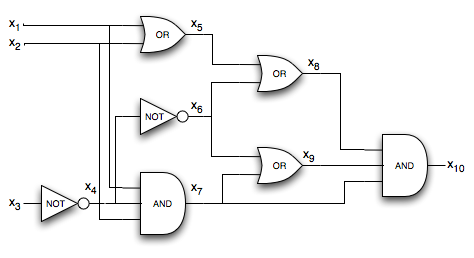

Otra manera de visualizar el problema es como un grafo bipartido : 


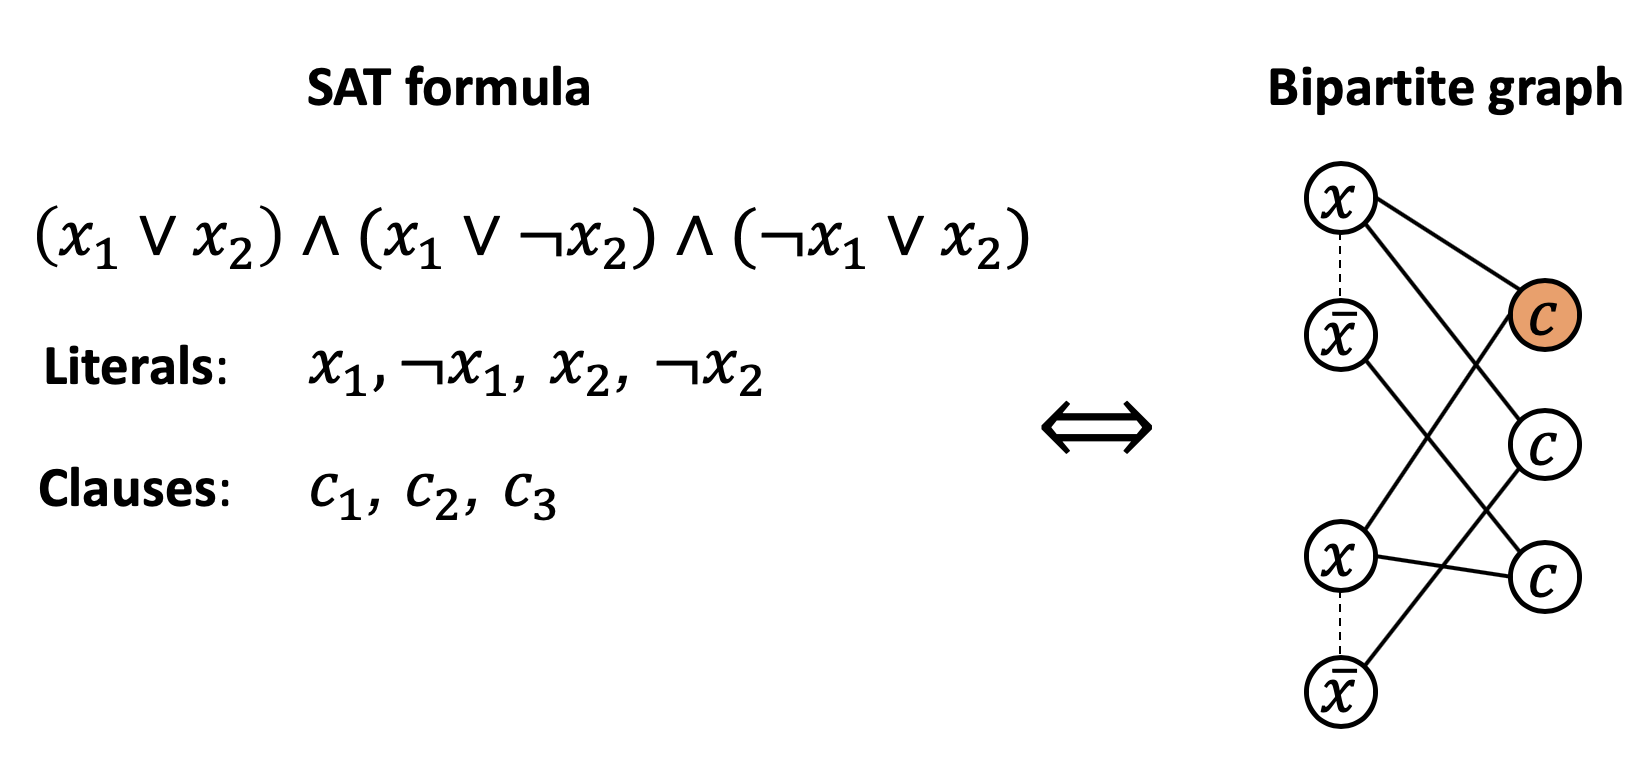

Un caso especial del SAT es el CNF SAT (Conjuctive Normal Form SAT), es decir, la fórmula booleana es un AND de cláusulas, cada uno siendo un OR de literales. Esto es interesante ya que toda fórmula en lógica proposicional puede transformarse en un equivalente en CNF.

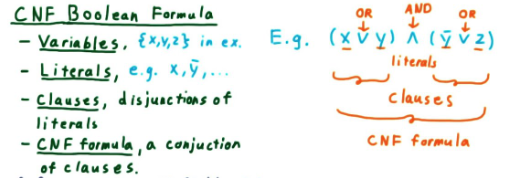

Un caso especial del CNF SAT es el 3-SAT (NP - Completo) donde las cláusulas son un OR de como máximo de tres literales (dicho de otra manera, respecto al grafo bipartido anterior, que el grado de cada cláusula (nodo) es 3).

Un caso especial del 3-SAT es el Monotone 3-SAT en donde cada cláusula son todas positivas o todas negativas. Obviamente para el caso que todas las cláusulas sean positivas establecemos todas las variables a VERDADERO o si todas las cláusulas sean negativas establecemos todas las variables a FALSO y el problema estaría resuelto. Pero cuando las cláusulas están entremezclada, es más difícil.

### Versiones de tiempo polinómico del SAT
- 2-SAT : la cláusula es un OR de 2 literales. Si tenemos x v y, por lógica preposicional; a=>b quiere decir que a o b son o VERDADERO o FALSO es lo mismo que decir que ¬a v b. Si a es FALSO la implicación no es relevante, pero si a es VERDADERO b también lo debe ser. Aplicándolo a x v y ≡ ¬x=>y o ¬y=>x (ya que es simétrico).

- MAX 2-SAT : dado una fórmula 2-SAT, satisfacer k cláusulas (maximizar k), el cual es NP - Hard ¿revisar si es NP-Hard?.

- Horn SAT (caso especial de CNF SAT) : es la generalización de 2-SAT en donde cada cláusula tiene <= 1 literal positivo, es decir, la fórmula será algo parecido a : ¬x v ¬y v ¬z v w (un positivo y los demás negados) y aplicando la Ley de Morgan es lo mismo que : ¬(x ʌ y ʌ z) v w ≡ (x ʌ y ʌ z) => w (si x,y,z son VERDADEROS, w tambén lo será).

- Dual Horn SAT : en donde cada cláusula tiene <= 1 literal negativo.

- DNF SAT (Disjunctive Normal Form SAT) : la fórmula es un OR de AND de literales, es decir, OR(AND(literales)).

Nota : k-SAT significa que cada cláusula contiene exactamente k literales. Un literal es una variable booleana x o su negación ¬x.


## Algoritmos para SAT

### Algoritmo Naive

Una primera aproximación es pensar en una implementación de un solver SAT que realiza una generación sistemática de combinaciones. El algoritmo devuelve verdadero y se detiene cuando una combinación evalúa la fórmula a 1. Si todas las combinaciones posibles se generan sin éxito, el algoritmo devuelve falso. Claramente, el peor de los casos la complejidad de este algoritmo es O(2^n), donde n es el número de literales en la fórmula booleana. Por ejemplo : 

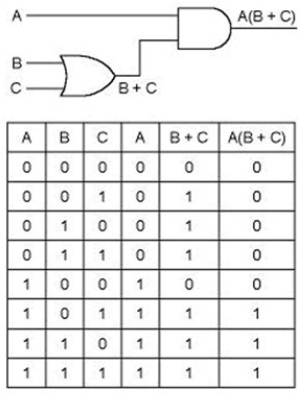

Para que los resultados de los algoritmos implementados se verifiquen correctamente, haremos uso del método check_solution:

In [4]:
def convertBool(values, ax):
    if ax < 0:
        au = -values[abs(ax)-1]
    else:
        au = values[abs(ax)-1]
    return True if au > 0 else False

# check if a solution is valid or not
def check_solution(values, clauses):
    sol = True
    for unit in clauses:
        aux = False
        for i in unit:
            aux = aux or convertBool(values, i)
        sol = sol and aux
    return "SATISFIABLE" if sol else "UNSATISFIABLE"

Probamos usando el Algoritmo Naive con la siguiente cláusula: (x or z or ¬y)(¬x or y or ¬z), donde:
       
       x = 1
       z = 2
       y = 3

In [ ]:
import itertools

clauses = [[1,2,-3], [-1,3,2]] # (x or z or ¬y)(¬x or y or ¬z)

def brute_force(clauses):
    literals = set([abs(y) for x in clauses for y in x])
    n = len(literals)

    for seq in itertools.product([True, False], repeat=n):
        res = set([lit if boo else -lit for boo, lit in zip(seq, literals)])
        if all([bool(set(x).intersection(res)) for x in clauses]):
            return True, dict(zip(range(1, n+1), seq))

    return False, None

val, solution = brute_force(clauses)
sat = "UNSATISFIABLE"

if val:
    sol = [0] * len(solution)
    for key, value in solution.items():
        sol[abs(key) - 1] = key if value else -key
    sat = check_solution(sol, clauses) # verify solution

if sat == "SATISFIABLE":
    print(solution)
    print("SATISFIABLE")
else:
    print("UNSATISFIABLE")


{1: True, 2: True, 3: True}
SATISFIABLE


Por lo que tenemos que para satiasfacer la fórmula, las variables deben asignarse de la siguiente manera:

    x = true
    z = true
    y = true

Este algoritmo funciona para fórmulas pequeñas ya que realiza una búsqueda exhaustiva que analiza todas las posibles combinaciones pero rápidamente para fórmulas con un número de cláusulas mayores es imposible obtener una solución en un tiempo razonable.

### Algoritmos Greedy/Local Search

#### WalkSAT/GSAT


Se le conoce como algoritmo incompleto porque, normalmente, solo puede verificar si es SAT. Veamos el algoritmo de WalkSAT (algoritmo de búsqueda local):
- Se elige aleatoriamente una asignación a cada literal
  - Si se cumple la cláusula, devuelve SAT
  - Si no se ha encontrado una solución, se selecciona un literal eligiendo la asignación contraria
- Se repite hasta que se encuentre una asignación que satisface la fórmula

WalkSAT y GSAT difieren en los métodos utilizados para seleccionar qué variable voltear (asigna lo contrario). GSAT realiza el cambio que minimiza el número de cláusulas insatisfechas en la nueva asignación, o con alguna probabilidad elige una variable al azar mientras que WalkSAT elige una cláusula que no está satisfecha con la asignación actual y voltea la variable dentro de esa cláusula

Existen muchas versiones de GSAT y WalkSAT. WalkSAT ha demostrado ser particularmente útil para resolver problemas de satisfacción producidos por la conversión de problemas de planificación automatizados. El enfoque de la planificación que convierte los problemas de planificación en problemas de satisfacción booleana se llama SATPLAN.

También conviene hablar de MaxWalkSAT, el cual es una variante de WalkSAT diseñada para resolver el problema de satisfacción ponderado, en el que cada cláusula se asocia con un peso, y el objetivo es encontrar una asignación que pueda o no satisfacer la fórmula completa, que maximice el peso total de las cláusulas satisfechas por esa asignación.

Probamos usando WalkSAT con la siguiente cláusula: (x or z or ¬y)(¬x or y or ¬z), donde:
       
       x = 1
       z = 2
       y = 3

In [2]:
import random

clauses = [[1,2,-3], [-1,3,2]] # (x or z or ¬y)(¬x or y or ¬z)

def getLiterals(clauses):
    return set([abs(y) for x in clauses for y in x])

def checkSAT(cl, assign):
    for c in cl:
        if assign[abs(c)] and c > 0:
            return True
        elif not assign[abs(c)] and c < 0:
            return True
    return False


def check(clauses, assign):
    for cl in clauses:
        if not checkSAT(cl, assign):
            return False
    return True


def walksat(clauses, max_flips, p, limit):
    literals = getLiterals(clauses)
    assign = {s: random.choice([True, False]) for s in literals}

    while limit:
        for _ in range(max_flips):

            if check(clauses, assign):
                return assign

            cl = random.choice(clauses)
            while not checkSAT(cl, assign):
                cl = random.choice(clauses)

            r = random.uniform(0, 1) < p
            if r:
                lit = abs(random.choice(cl))
                assign[lit] = not assign[lit]
            else:
                flip = 0
                satClauses = 0
                for symb in cl:
                    mod = assign.copy()
                    mod[abs(symb)] = not mod[abs(symb)]

                    j = 0
                    for claus in clauses:
                        if checkSAT(claus, mod):
                            j += 1

                    if j > satClauses:
                        satClauses = j
                        flip = abs(symb)

                assign[flip] = not assign[flip]
        limit -= 1
    return False


def walksat_algorithm(clauses):
    max_flips = 50000
    p = 0.6
    res = walksat(clauses, max_flips, p, 5)

    if res:
        return True, res
    else:
        return False, None

val, solution = walksat_algorithm(clauses)
sat = "UNKNOWN"

if val:
    sol = [0] * len(solution)
    for key, value in solution.items():
        sol[abs(key) - 1] = key if value else -key
    sat = check_solution(sol, clauses) # verify solution

if sat == "SATISFIABLE":
    print(solution)
    print("SATISFIABLE")
else:
    print("UNKNOWN")

NameError: ignored

Por lo que tenemos que para satiasfacer la fórmula, las variables deben asignarse de la siguiente manera:

    x = false
    z = true
    y = false

#### Constraint weighting o Breakout Method


Una manera de escapar de los mínimos locales es usar una suma ponderada de restricciones violadas como una medida de coste y cambiar algunos pesos cuando no hay un movimiento de mejora disponible. Más precisamente, si ningún cambio reduce el coste de la asignación, el algoritmo aumenta el peso de las restricciones violadas por la asignación actual.

De esta manera, cada movimiento que de otro modo no cambiaría el coste de la solución lo disminuye. Además, el peso de las restricciones que siguen siendo violadas por un gran número de movimientos sigue aumentando. Por lo tanto, durante una serie de movimientos que no satisfacen una restricción, el coste de los movimientos a asignaciones que satisfacen esa restricción sigue aumentando.


Véase que aparte de estos algoritmos greedy (y muchos más como *Hill Climing*), se puede aplicar **Algoritmos Genéticos** (cabe resaltar que se encontró
que existen muy pocas referencias a la utilización de este tipo de métodos en la solución de problemas de satisfactibilidad) y otros métodos estocásticos de búsqueda local como **Tabu Search** o **Simulated Annealing** para resolver problemas SAT.

### Algoritmo Davis-Putnam (DP)

Existen algunas reglas básicas sobre lógica proposicional que conviene recordar:

Un literal es puro si solo ocurre como un literal positivo o como un
literal negativo en una fórmula CNF. Por ejemplo : ϕ = (¬x1 ∨ x2) ∧ (x3 ∨ ¬x2) ∧ (x4 ∨ ¬x5) ∧ (x5 ∨ ¬x4). Vemos que x1 y x3 son literales puros. 

Por lo que tenemos el **lema del literal puro** : cláusulas que contienen literales puros pueden ser eliminadas de la fórmula booleana ya que siempre pueden ser asignadas de manera que haga que todas las cláusulas que las contienen sean verdaderas.

Por ejemplo la fórmula ϕ = (¬x1 ∨ x2) ∧ (x3 ∨ ¬x2) ∧ (x4 ∨ ¬x5) ∧ (x5 ∨ ¬x4) se convierte en ϕ = (x4 ∨ ¬x5) ∧ (x5 ∨ ¬x4)

Una cláusula C es unitaria si C tiene sólo un literal.

Por lo que tenemos la **eliminación unitaria** (también llamada BCP): sean S un conjunto de cláusulas y {L} una cláusula unitaria de S. Entonces la eliminación unitaria de L en S es el conjunto obtenido borrando en S todas las cláusulas que contienen L y borrando L en todas las cláusulas. Por ejemplo: 

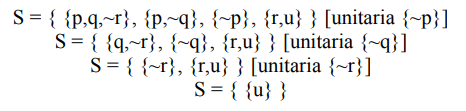


La **regla de Resolución Lógica** : dos cláusulas CNF que contienen una variable x en fases opuestas (polaridades) implican una nueva cláusula CNF que contiene todos los literales excepto x y ¬x. Por ejemplo: (x or α)(¬x or β) se convierte en (α or β).

El primer intento de mejorar el Algoritmo Naive fue en 1960 desarrollado por  Martin Davis y Hilary Putnam. Es un algoritmo basado en la regla de Resolución Lógica (Resolution).

Es una forma de resolución en la cual las variables son elegidas iterativamente y eliminadas mediante la regla de Resolución Lógica de cada cláusula en la que la variable aparece afirmada, con una cláusula en la que la variable es negada. 
En cada paso, la cláusula intermedia generada es equisatisfactable, pero posiblemente no equivalente, a la cláusula original.
- Se aplica iterativamente los siguientes pasos:
    - Se selecciona una variable x
    - Se aplica la regla de Resolución Lógica para cada par de cláusulas de la forma (x or α)(¬x or β)
    - Se eliminan todas las cláusulas que contienen x o ¬x
    - Se aplica el lema del literal puro y eliminación unitaria
- El algoritmo acaba cuando se llega a una cláusula vacía (UNSAT) o sino, es satisfacible (SAT).

Por ejemplo, si aplicamos DP para las siguientes cláusulas:

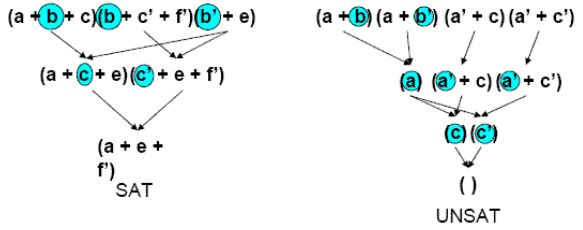

En el primer ejemplo el algoritmo se resuelve en b, y luego en c. Como no es posible seguir aplicando las reglas, el algoritmo se detiene; como la cláusula vacía no se pudo derivar, el resultado es satisfactorio. En el segundo caso, se resuelve la fórmula dada en b, luego en a, luego en c y produce la cláusula vacía; por lo tanto, el algoritmo devuelve no satisfactorio.


### Algortimo Davis-Putnam-Logemann-Loveland (DPLL/DLL)

El algoritmo DDPL (también conocido como DLL) está basado en la vuelta atrás que sirve para decidir la satisfactibilidad de las fórmulas. Fue presentado en 1962 por Martin Davis, Hilary Putnam, George Logemann y Donald W. Loveland y es una refinación del previo algoritmo DP (ya que el algoritmo original era ineficiente). Forma la base para los solvers de SAT completos más eficientes de hoy.

El algoritmo de *backtracking* recursivo se ejecuta eligiendo un literal, asignándole un valor de verdadero, simplificando la fórmula y luego verificando recursivamente si la fórmula simplificada es satisfactoria; si este es el caso, la fórmula original es satisfactoria; de lo contrario, se realiza la misma verificación recursiva asumiendo el valor de verdad opuesto (es decir, asignando el literal a falso). Esto se conoce como la **regla de división**, ya que divide el problema en dos subproblemas más simples. 
El algoritmo DPLL mejora sobre el algoritmo de *backtracking* mediante el uso de las reglas de la eliminación unitaria y lema del literal puro.
- En cada paso:
    - [DECIDE] Selecciona un literal a asignar
    - [DEDUCE] Se aplica la eliminación unitaria y (opcionalmente) el lema del literal puro
    - [DECIDE] Si existe conflicto, entonces se realiza *backtracking*
        - Si no se puede realizar *backtracking*, devuelve UNSAT
    - Si la fórmula es satisfacible, devuelve SAT

Pero en el *branching* (literal a asignar)... ¿cuál se debe eligir? Esto se determina con una heurística. Las más conocidas son: Jeroslow Wang, Random Selection, Most Often, Shortest Positive Clause, Freeman, Jeroslow Wang 2 Sided, Dynamic Largest Individual Sum (DLIS), ... 

Veamos un ejemplo del algoritmo para la siguiente cláusula (el literal escogido será el primero que se encuentre): 

(¬a or b or c) (a or c or d) (a or c or ¬d) (a or ¬c or d) (a or ¬c or ¬d) (¬b or ¬c or d) (¬a or b or ¬c) (¬a or ¬b or c)


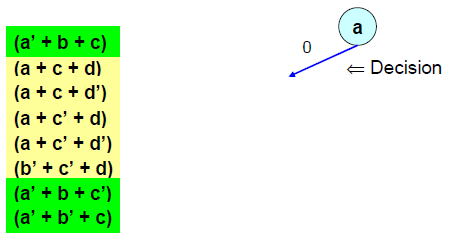

Escoge un literal y decide que a = 0, esto produce que algunas cláusulas ya se conviertan satisfactioria (color verde).

Después de varias decisiones, se observa que esta rama lleva a un conflicto: 
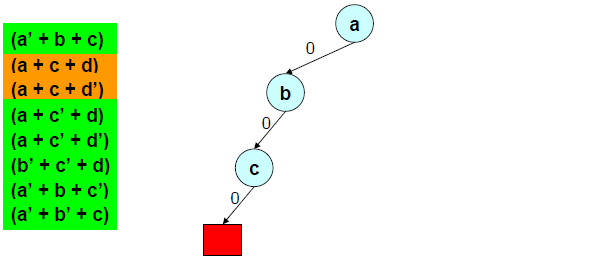

Por lo que se realiza *backtracking* al nivel anterior y por la fuerza asigne un valor opuesto a esa variable, pero observamos que esto también lleva a otro conflicto por lo que se vuelve a realizar *backtracking*:

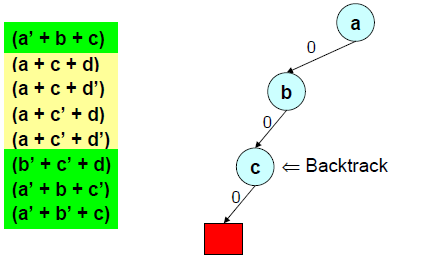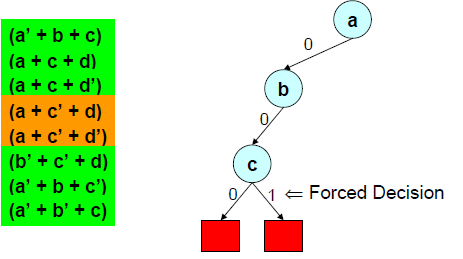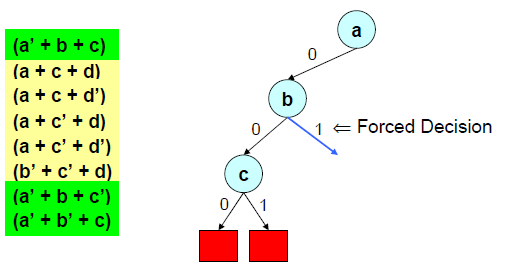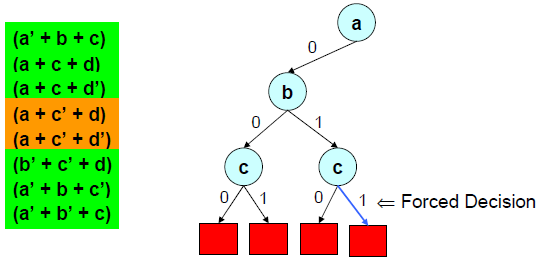

Se llega que no se encuentra una solución por la rama izquierda del árbol, por lo que se procede a explorar la rama derecha (asignando al literal "a" el opuesto a = 1):



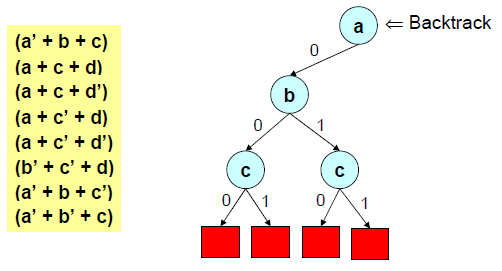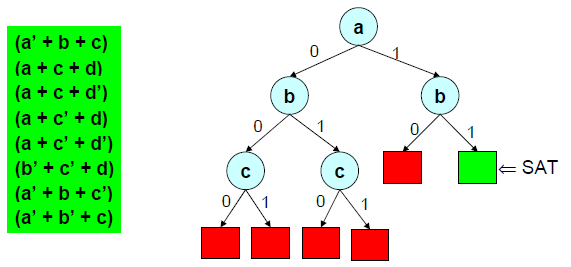

En donde se encuentra una solución que satisface la cláusula.

Probamos usando el Algoritmo DPLL (junto a la heurística Jeroslow Wang 2 Sided) con la siguiente cláusula: (x or z or ¬y)(¬x or y or ¬z):

In [ ]:
clauses = [[1,2,-3], [-1,3,2]] # (x or z or ¬y)(¬x or y or ¬z)

def bcp(clauses, unit):
    clausX = []
    for cl in clauses:
        if unit in cl:
            continue
        if -unit in cl:
            new_cl = [x for x in cl if x != -unit]
            if not new_cl:
                return -1
            clausX.append(new_cl)
        else:
            clausX.append(cl)
    return clausX


def pure_literal(clauses):
    literals = set([y for x in clauses for y in x])
    assign = []
    pures = [x for x in literals if -x not in literals]
    for pure in pures:
        clauses = bcp(clauses, pure)
    assign += pures
    return clauses, assign


def unit_propagation(clauses):
    assign = []
    units = [c for c in clauses if len(c) == 1]
    while units:
        unit = (units[0])[0]
        clauses = bcp(clauses, unit)
        assign.append(unit)
        if clauses == -1:
            return -1, []
        if not clauses:
            return clauses, assign
        units = [c for c in clauses if len(c) == 1]
    return clauses, assign


def jeroslow_wang_2_sided(clauses, weight=2):
    aux = {}
    for cl in clauses:
        for lit in cl:
            # Siendo weight=2, len(cl)=3 -> 2^(-3)=0.125
            if abs(lit) in aux:
                aux[abs(lit)] += weight ** -len(cl)
            else:
                aux[abs(lit)] = weight ** -len(cl)
    return aux


def heuristic_selector(clauses):
    # Se devuelve aquel literal que tenga un mayor valor.
    aux = jeroslow_wang_2_sided(clauses)
    return max(aux, key=aux.get)


def dpll(clauses, assign):
    clauses, pure_assignment = pure_literal(clauses)
    clauses, unit_assignment = unit_propagation(clauses)
    assign.extend(pure_assignment + unit_assignment)

    if clauses == - 1:
        return []
    if not clauses:
        return assign

    variable = heuristic_selector(clauses)
    solution = dpll(bcp(clauses, variable), assign + [variable])
    if not solution:
        solution = dpll(bcp(clauses, -variable), assign + [-variable])
    return solution


def dpll_algorithm(clauses):
    literals = set([abs(y) for x in clauses for y in x])

    res = dpll(clauses, [])
    if res:
        res.extend([x for x in literals if x not in res and -x not in res])
        res.sort(key=lambda x: abs(x))
        return True, dict(zip(literals, [True if x > 0 else False for x in res]))
    else:
        return False, None

val, solution = dpll_algorithm(clauses)
sat = "UNSATISFIABLE"

if val:
    sol = [0] * len(solution)
    for key, value in solution.items():
        sol[abs(key) - 1] = key if value else -key
    sat = check_solution(sol, clauses) # verify solution

if sat == "SATISFIABLE":
    print(solution)
    print("SATISFIABLE")
else:
    print("UNSATISFIABLE")

{1: True, 2: True, 3: True}
SATISFIABLE


Por lo que tenemos que para satiasfacer la fórmula, las variables deben asignarse de la siguiente manera:

    x = true
    z = true
    y = true

Nota: en los solvers la mayoría del tiempo es empleado en BCP, por lo que optimizando esa parte del algoritmo, el algoritmo mejora rápidamente.

### Algoritmo con Constraint Programming

Se ha implementado también el problema mediante Programación con Restricciones mediante un solver que se usa específicamente para el problema SAT en Python. Para ello se debe instalar la librería:

In [ ]:
!pip install --upgrade --user ortools

Probamos usando la siguiente cláusula: (x or z or ¬y)(¬x or y or ¬z):

In [7]:
from ortools.sat.python import cp_model

clauses = [[1,2,-3], [-1,3,2]]

def ortools_solver(clauses):
    n = max(getLiterals(clauses)) + 1
    literals = range(1, n)
    boolLit = [0]

    model = cp_model.CpModel()

    for x in literals:
        boolLit.append(model.NewBoolVar(str(x)))

    for cl in clauses:
        cl_rep = [boolLit[a] if a > 0 else boolLit[abs(a)].Not() for a in cl]
        model.AddBoolOr(cl_rep)

    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        sol = {}
        boolLit.remove(0)
        for x, y in zip(literals, boolLit):
            sol[x] = True if solver.Value(y) == 1 else False
        if status == cp_model.OPTIMAL:
            return True, sol
        else:
            return False, sol
    else:
        return False, None

val, solution = ortools_solver(clauses)
sat = "UNSATISFIABLE"
if val:
    sol = [0] * len(solution)
    for key, value in solution.items():
        sol[abs(key) - 1] = key if value else -key
    sat = check_solution(sol, clauses) # verify solution

if sat == "SATISFIABLE":
    print(solution)
    print("SATISFIABLE")
else:
    print("UNSATISFIABLE")

{1: False, 2: False, 3: False}
SATISFIABLE


Por lo que tenemos que para satiasfacer la fórmula, las variables deben asignarse de la siguiente manera:

    x = false
    z = false
    y = false

### Algoritmo MIP

Se ha implementado una versión del SAT con MIP, debido al inconveniente de la licencia de Gurobi no es posible ejecutar el siguiente código en el Notebook aunque más adelante se mostrará la salida. 

Resolvemos con el Gurobi, por ejemplo, la siguiente cláusula: (x or z or ¬y) (¬x or y or ¬z):

In [ ]:
import gurobipy as gp
from gurobipy import GRB

clauses = [[1,2,-3], [-1,3,2]]

def gurobi_solver(clauses):
    n = max(getLiterals(clauses)) + 1
    literals = range(1, n)

    model = gp.Model("MIP_SAT")
    Lit = model.addVars(literals, vtype=GRB.BINARY, name="X")
    NotLit = model.addVars(literals, vtype=GRB.BINARY, name="NotX")

    Cla = model.addVars(len(clauses), vtype=GRB.BINARY, name="Clause")

    Obj0 = model.addVar(vtype=GRB.BINARY, name="Obj0")
    Obj1 = model.addVar(vtype=GRB.BINARY, name="Obj1")

    # Link Xi and notXi
    model.addConstrs((Lit[i] + NotLit[i] == 1.0 for i in literals), name="CNSTR_X")

    # Link clauses and literals
    for i, c in enumerate(clauses):
        clause = []
        for l in c:
            if l < 0:
                clause.append(NotLit[abs(l)])
            else:
                clause.append(Lit[l])
        model.addConstr(Cla[i] == gp.or_(clause), "CNSTR_Clause" + str(i))

    # Link objs with clauses
    model.addConstr(Obj0 == gp.min_(Cla), name="CNSTR_Obj0")
    model.addConstr((Obj1 == 1) >> (Cla.sum() >= n), name="CNSTR_Obj1")

    # Set optimization objective
    model.setObjective(Obj0 + Obj1, GRB.MAXIMIZE)
    model.optimize()

    objval = model.getAttr(GRB.Attr.ObjVal)
    if objval > 0.9:
        solution = {}
        for key, value in model.getAttr('x', Lit).items():
            solution[key] = True if value > 0.9 else False
        return True, solution

    return False, None

val, solution = gurobi_solver(clauses)
sat = "UNSATISFIABLE"

if val:
    sol = [0] * len(solution)
    for key, value in solution.items():
        sol[abs(key) - 1] = key if value else -key
    sat = check_solution(sol, clauses) # verify solution

if sat == "SATISFIABLE":
    print(solution)
    print("SATISFIABLE")
else:
    print("UNSATISFIABLE")

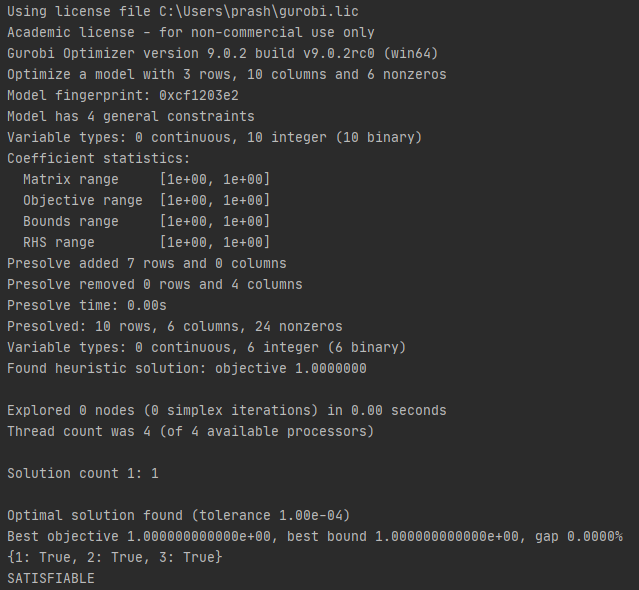

Por lo que tenemos que para satiasfacer la fórmula, las variables deben asignarse de la siguiente manera:

    x = true
    z = true
    y = true

### Algoritmo Conflict-Driven Clause-Learning (CDCL)

DPLL tiene tres deficiencias. Primero, toma decisiones ingenuas. Segundo, cuando encuentra un conflicto, no aprende nada más del conflicto además del hecho de que la asignación parcial actual condujo al conflicto. Y tercero, solo puede retroceder un nivel, lo que puede hacer que siga explorando un espacio de búsqueda que está condenado a fallar.

El aprendizaje de cláusulas controladas por conflictos (CDCL) mejora en los tres aspectos ya que aprovechan la estructura lógica del problema como avances en IA (búsqueda y aprendizaje). En el CDCL, durante la búsqueda de retroceso o *backtracking*, para cada conflicto, se aprende una nueva cláusula, que explica y evita la repetición del mismo conflicto, por ejemplo:
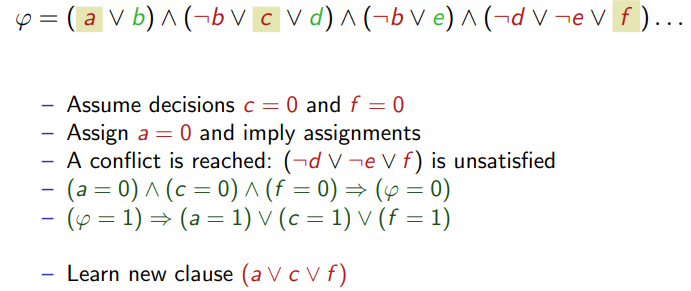



Durante la búsqueda de retroceso, para cada conflicto retrocede a uno de
las causas del conflicto (**Non-Chronological Backtracking**):

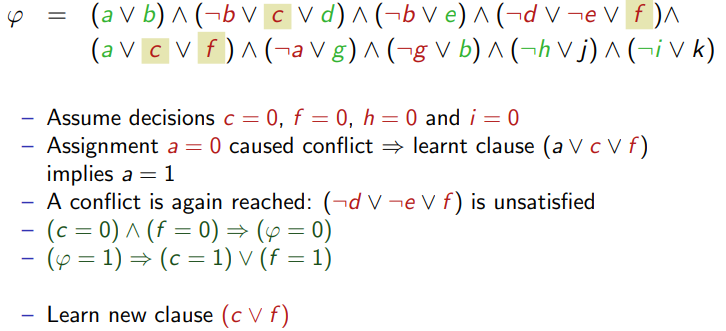

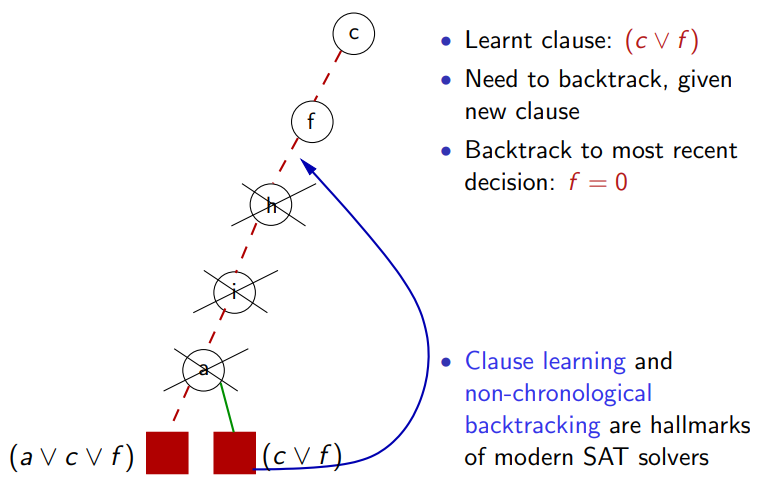

Existe otro método de vuelta atrás pero que hoy en día no se usa (Most Recent Backtracking Scheme):

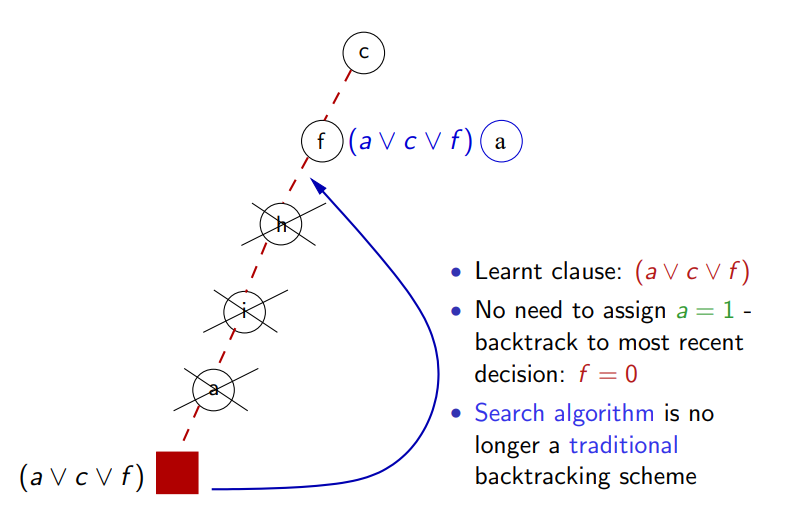

Cuando CDCL llega a un conflicto, analiza las conjeturas que ha realizado y todas las tareas que se vio obligado a inferir a través de BCP, lo que finalmente condujo al conflicto. Si graficamos estas conjeturas y sus implicaciones, obtenemos un grafo llamado **grafo de implicación**. Este es el grafo de las decisiones que tomó, los literales que fueron BCP y por qué, y cómo llegó al conflicto. Al mirar este grafo, CDCL puede aprender una cláusula que es potencialmente más útil que solo saber que la asignación parcial actual era mala. De esta manera, CDCL puede evitar cometer el mismo error una y otra vez y omitir grandes porciones de asignaciones parciales incorrectas DPLL se quedará atascado.



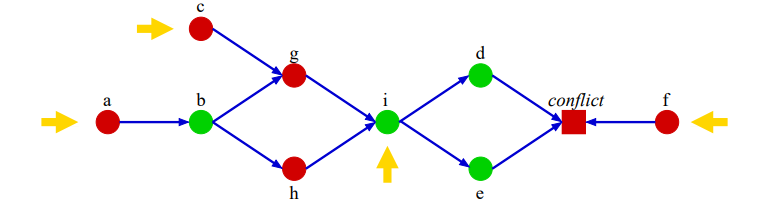

Lo bueno de la cláusula aprendida es que permite que CDCL aprenda de sus errores e ignore grandes secciones del espacio de búsqueda que nunca satisfarán la fórmula.
Una vez que CDCL haya aprendido una cláusula, CDCL podrá retroceder potencialmente más de un nivel, y BCP usará la cláusula aprendida para poner en práctica lo que aprendió de inmediato. La capacidad de retroceder más de un nivel con la cláusula aprendida es lo que llamamos, como vimos anteriormente, retroceso no cronológico (Non-Chronological Backtracking).

Por lo tanto, DPLL supera a DP al evitar el consumo exponencial de memoria y CDCL supera a DPLL al podar y reordenar el espacio de búsqueda sobre la marcha.

Veamos el pseudocódigo de un algoritmo básico CDCL:

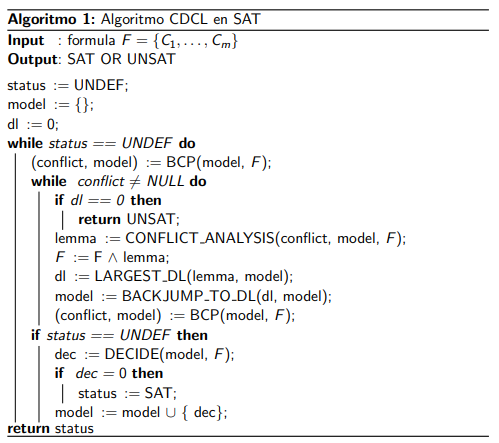

Usaremos un solver de Python que utiliza algoritmos CDCL llamado Glucose3. Para usar el solver del SAT se debe instalar e importar las siguientes librerías:

In [ ]:
!pip install python-sat[pblib,aiger]
!pip install python-sat
!pip install -U python-sat
from pysat.solvers import Glucose3

Resolvemos con el solver, por ejemplo, la siguiente cláusula: (x or z or ¬y)(¬x or y or ¬z):

In [ ]:
clauses = [[1,2,-3], [-1,3,2]]

def cdcl_solver(clauses):
    literals = set([abs(y) for x in clauses for y in x])
    n = len(literals) + 1

    g = Glucose3()
    for cl in clauses:
        g.add_clause(cl)

    a = g.solve()
    b = dict(zip(range(1, n), [True if x > 0 else False for x in g.get_model()])) if a else None
    return a, b

val, solution = cdcl_solver(clauses)
sat = "UNSATISFIABLE"

if val:
    sol = [0] * len(solution)
    for key, value in solution.items():
        sol[abs(key) - 1] = key if value else -key
    sat = check_solution(sol, clauses) # verify solution

if sat == "SATISFIABLE":
    print(solution)
    print("SATISFIABLE")
else:
    print("UNSATISFIABLE")

{1: False, 2: False, 3: False}
SATISFIABLE


Por lo que tenemos que para satiasfacer la fórmula, las variables deben asignarse de la siguiente manera:

       x = false
       y = false
       z = false

La investigación SAT implica modificar todos los aspectos de los algoritmos, por ejemplo:
  - codificaciones mejoradas de la fórmula de entrada en forma CNF
  - técnicas para simplificar la fórmula antes y durante el procesamiento
  - heurística para elegir el orden de los literales de decisión 
  - decidir qué cláusulas aprender
  - decidir cuándo descartar cláusulas aprendidas (demasiadas ralentizarán las operaciones)
  - elegir reiniciar la búsqueda en un orden diferente (retener las cláusulas aprendidas)
  - estructuras de datos especializadas para operaciones rápidas 
  - trabajar en la resolución SAT paralela (a diferencia de DPLL, dividir los problemas de CDCL es difícil)

Los algoritmos CDCL se usan en casi todos los solvers SAT modernos:
  - mejor que DPLL en la práctica (menos para ejemplos SAT aleatorios)
  - puede resolver instancias con cientos de miles de variables y
decenas de millones de cláusulas
  - por otro lado, demasiadas cláusulas pueden ralentizar las operaciones del algoritmo
  - en la práctica, las cláusulas también se eliminan periódicamente durante las ejecuciones del solver SAT

## Aplicaciones del SAT


Son múltiples las aplicaciones practicas del problema SAT, pero la primera y más obvia es a otros problemas NP-completos tales como la coloración de grafos, el problema del agente viajero: 


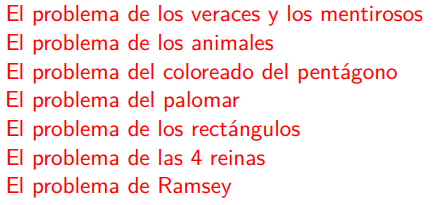

Otras aplicaciones de SAT son: Job Shop Scheduling, diseño de circuitos VLSI, así como muchos otros problemas de razonamiento en Inteligencia Artificial.

Cabe mencionar que el problema SAT, está tomando gran importancia en muchas áreas de la IA, por ejemplo, Kautz y Selman mostraron una forma de codificar problemas de *planning* como problemas SAT y demuestran que realizar esa transformación además de permitirles tener un marco de trabajo más flexible para incluir diferentes tipos de restricciones en los planes, también refleja más confiablemente la teoría detrás de los modernos sistemas de planeación basados en restricciones.